In [5]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

In [8]:
X, y = mnist['data'], mnist['target']
print(X.shape, y.shape)

(70000, 784) (70000,)


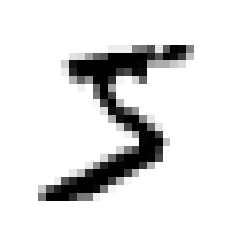

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()


In [4]:
y[0]

'5'

In [6]:
import numpy as np
import pandas as pd

y = y.astype(np.uint8)

In [9]:
# 항상 데이터를 자세히 조사하기 전에 테스트 세트 따로 만들어두기

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))




0.9669
0.91625
0.96785


In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')


array([0.95035, 0.96035, 0.9604 ])

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [17]:
# confusion matrix 오차 행렬을 이용하여 분류기의 성능 평가

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)


In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
# true negative, false positive

array([[53892,   687],
       [ 1891,  3530]])

정밀도 : TP/(TP+FP) 양성중 실제 양성비율 : precision score


재현율 : TP/(TP+FN) 양성중 찾아낸 비율  : recall score

In [21]:
# 정밀도와 재현율

from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))


0.8370879772350012
0.6511713705958311


In [25]:
# 정밀도와 재현율을 둘다 고려한 조화평균 F

from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)



0.7325171197343846

In [27]:
# 사이킷런에서 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인 가능 => 그것을 이용하여 원하는 임곗값을 정해 예측을 만들 수 있음

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [29]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [30]:
# 적절한 임계값을 구하기 
# predict은 bool값 반환, decision_function은 결점 점수 반환

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method='decision_function')


In [31]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) 

In [40]:
# 맷플롯립을 이용해 그래프 그려보기

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = ' recall')
    plt.legend(loc='center right', fontsize = 16)
    plt.xlabel('Threshold', fontsize = 16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0 , 1])


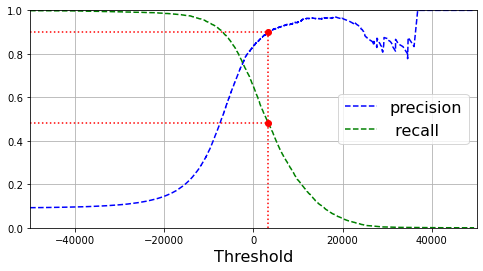

In [41]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], 'ro')
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')
plt.show()

In [42]:
# RandomForestClassifier와 SGDClassifier의 roc곡선과 roc-auc 점수 비교 => 곡선 비교는 그래프라 안함
# 랜덤포레스트는 decision_function()메서드가 없고 predict_proba()가 존재


from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method='predict_proba')


In [48]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_train_5, y_scores))
print(roc_auc_score(y_train_5, y_scores_forest))



0.9604938554008616
0.9983436731328145


###다중 분류###

이미지 분류지 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택 OvR, OvA라고 함(one-versus-the-rest, one-versus-all)


OvO : one-versus-one 전략, 비교할 클래스를 모든 클래스와 각각 모두 비교, 장점 : 훈련세트에 필요한 두개의 세트만 있으면 됨

In [49]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])



array([5], dtype=uint8)

In [50]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [51]:
np.argmax(some_digit_scores)

5

In [52]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [57]:
svm_clf.classes_[5]
# svm_clf에서 클래스 값과 인덱스 값이 같은 경우는 드뭄

5

In [12]:
# SVC기반으로 OvR전략을 사용하는 다중 분류기 만들기

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])




array(['5'], dtype='<U1')